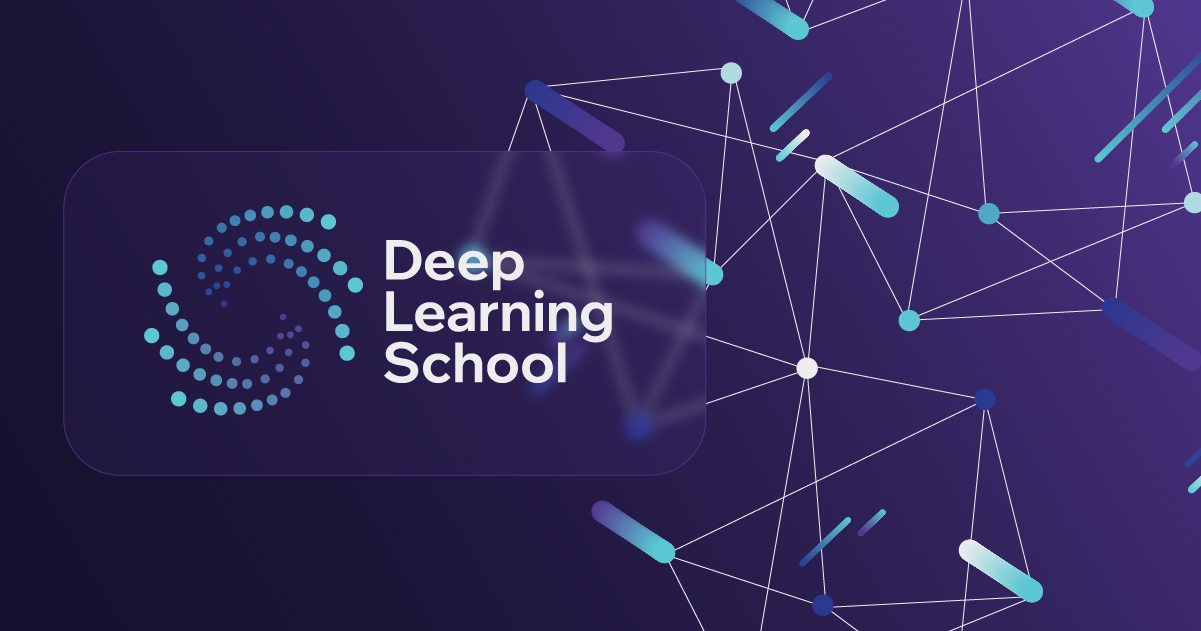

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h1 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h1>



В этом занятии нам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.

Для каждого датасета мы будет реализовывать стандартную логику обучения моделей:
1. Подготовим данные
2. Создадим модель (напишем класс модели)
3. Создадим функции обучения на тренировочных данных и применения модели к тестовым данным
4. Проведем обучение, оценим результаты работы моделей

Начнем с импорта необходимых библиотек

In [3]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader
import random
from tqdm.notebook import tqdm

import copy

sns.set(style="darkgrid", font_scale=1.4)

In [4]:
# Reduce stochasticity

SEED = 42

# PyTorch
torch.manual_seed(SEED)

# CUDA (GPU)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # For multi-GPU setups

# NumPy
np.random.seed(SEED)

# Python's built-in random
random.seed(SEED)

In [5]:
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms(True)

# Часть 1. Датасет moons


## Часть 1.1. Подготовка данных
Давайте сгенерируем датасет и посмотрим на него!

In [6]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

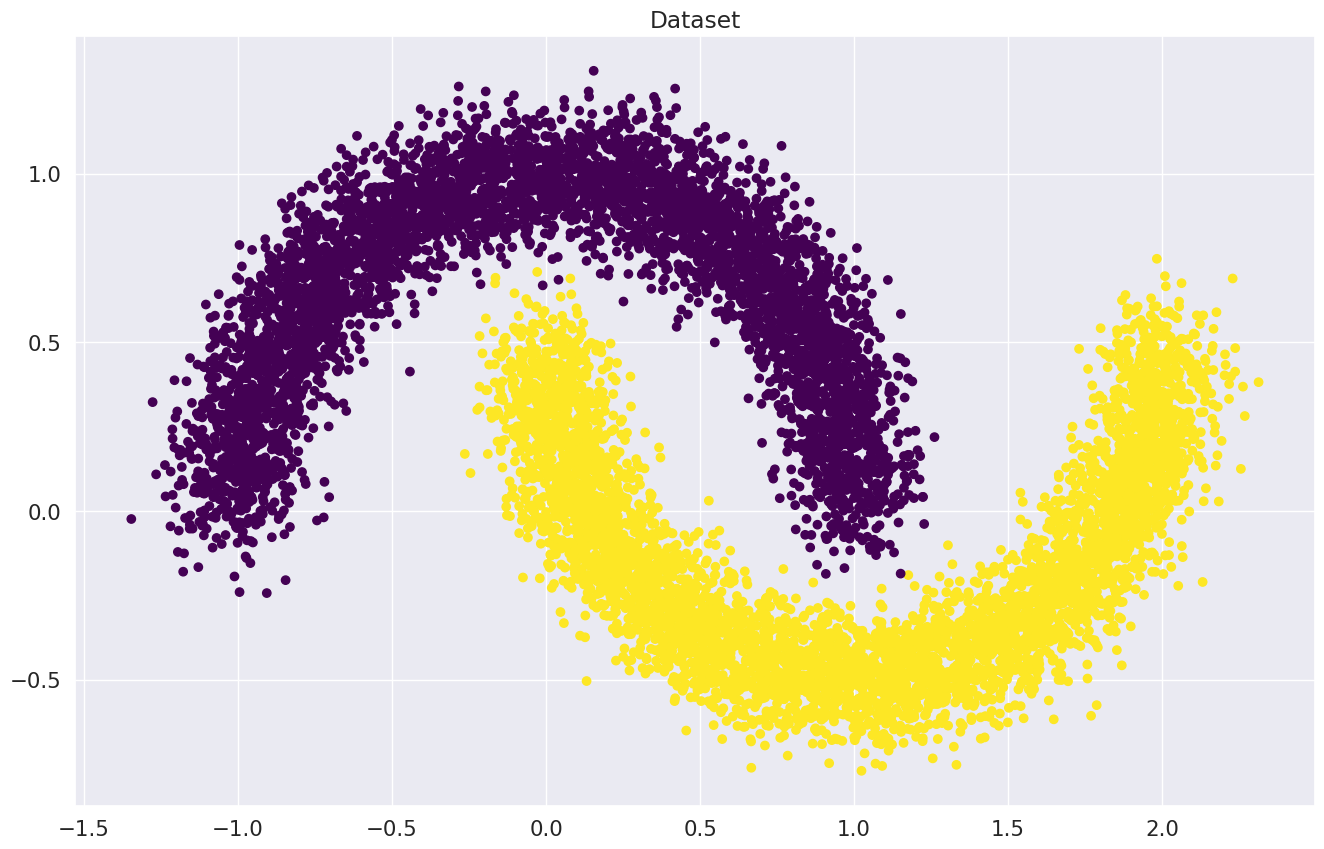

In [7]:
# Визуализация данных

plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

In [9]:
X_val

array([[ 0.79241146, -0.58157347],
       [ 1.55197607, -0.25105887],
       [-1.01348377,  0.24401524],
       ...,
       [ 1.07489681, -0.57691399],
       [ 0.54217974,  0.76081641],
       [-0.23809456,  1.09172219]])

### Задание. Загрузчики данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

Создайте тензоры с обучающими и тестовыми данными

In [10]:
torch.tensor(X_train, dtype=torch.float32)

tensor([[ 0.5020, -0.3376],
        [-0.0200,  0.2391],
        [ 0.5703,  0.8117],
        ...,
        [ 0.3216, -0.3567],
        [ 2.0134,  0.0323],
        [ 0.1791,  0.9310]])

In [11]:
X_train_t = torch.tensor(X_train, dtype=torch.float32) # ИЛИ torch.from_numpy(X_train).float()
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32)
# y_val_t.dtype -> torch.float32

Создаем `Dataset` и `DataLoader`.

Подумайте, нужно ли использовать `shuffle` для:


*   train data
*   validation data

Почему вы приняли такое решение?

**Ответ**:
* Выборку в трейне перемешивать надо, чтобы модель получила более репрезентативные данные для обучения. На валидационной выборке модель не учится -> перемешивать ее не нужно.




In [12]:
X_train_t, y_train_t

(tensor([[ 0.5020, -0.3376],
         [-0.0200,  0.2391],
         [ 0.5703,  0.8117],
         ...,
         [ 0.3216, -0.3567],
         [ 2.0134,  0.0323],
         [ 0.1791,  0.9310]]),
 tensor([1., 1., 0.,  ..., 1., 1., 0.]))

In [13]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)

## Часть 1.2. Класс модели
**Напоминание.** Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак $X$ и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно, на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к классу 1, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидой. Чаще всего в качестве сигмоиды берут:
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

Модель логистической регрессия - это по сути **нейронная сеть**  с одним линейным слоем и функцией активации сигмоида. Обученная модель возвращает прогнозы вероятностей классов для каждого обхекта, по которым можно рассчитать наиболее вероятный класс для каждого объекта.

В первой части задания мы на этой знакомой нам модели потренируем технику работы с нейронными сетями.

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch, реализующий линейную модель для расчета $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [14]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x =  torch.matmul(x, self.weights)
        if self.bias:
            x += self.bias_term
        return x.squeeze()

Обартите внимание, что мы предлагаем использовать [BCEWithLogitsLoss](https://docs.pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html), которая работает непосредственно с логитами, в отличие от [BCELoss](https://docs.pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), куда мы передаём уже значения вероятностей (после операции `sigmoid`).


In [15]:
linear_regression = LinearRegression(in_features = 2, out_features = 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

**Ответ:**

In [16]:
# Ответ: 3 параметра - 2 входных и 1 выходной

# проверка
sm_params = 0
for i in linear_regression.parameters():
  sm_params += 1
print(sm_params + 1) # + 1 - один выходной слой

3


## Часть 1.3. Функции для работы с моделью (обучение и предсказание)

### Задание. Функция обучения

Перейдём непосредственно к обучению.

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обнуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy`.

Реализуем цикл обучения в виде функции, которая будет принимать в качестве параметров нашу модель, данные (созданный ранее DataLoader), оптимизатор и функцию потерь и проводить обучение (т.е. пересчитывать и обновлять веса модели) до выполнения определенных условий. Функция будет возвращать список из лоссов на всех батчах в цикле обучения и список из наборов всех значений параметров модели (weights и bias_term) по всем эпохам цикла обучения.

Значения параметров мы будем сохранять на случай, если модель переобучится и будут нужны не последние значения, а более старые. Можно было бы сохранять значения параметров не по всем, а по нескольким последним эпохам, но для простоты сохраним по всем эпохам.

Цикл обучения будет остановливаться при выполнении одного из двух условий:
- достижение максимального количества эпох
- замедление снижения валидационной метрики (например, чтобы модель не переобучилась).

Поскольку пока мы с вами еще не определились с метрикой, давайте следить за изменением `loss` (остановка цикла, если разность между усредненными значениями loss в текущей и предыдущей эпохах меньше определенного порога)

Максимальное количество эпох и порог, с которым будем сравнивать разницу усредненных значений loss между эпохами, мы также будем передавать в функцию в качестве параметров.  

**Комментарий**

Следить и сравнивать изменение `train loss` может не всегда корректно отображать ситуацию с обучением. Например, иногда в диффузионных моделях при обучении функция потерь довольно быстро начинает колебаться в окресности одного значения, однако качество генерации картинок еще долго может улучшаться. Однако в данном примере можно использовать прекращение изменения лосса как критерий остановки.

In [17]:
# выход по лоссу
def train_model(model, train_dataloader, optimizer, loss_func, max_epochs, tol = 1e-3):
  '''
  args:
    model - модель для обучения
    train_dataloader - loader с обучающей выборкой
    optimizer - оптимизатор, взятый из модуля `torch.optim`
    loss_func - функция потерь, взятая из модуля `torch.nn`
    max_epochs - максимальное количество эпох обучения
    tol - порог, с которым будет сравниваться изменение loss, усредненного по эпохе
  '''

  # создадим переменные (на данный момент - пустые списки), куда будем сохранять
  # лоссы по батчам, усредненные по эпохе лоссы и параметры модели
  batch_losses = []
  epoch_mean_losses = []
  model_param_dict = []

  for epoch in range(max_epochs):
    losses = []    # переменная losses - список, куда будем добавлять значения loss по каждому батчу текущей эпохи
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        # Далее далее по коду идут стандартные операции цикла обучения:
        optimizer.zero_grad()

        outp = model(X_batch)
        loss = loss_func(outp, y_batch.squeeze())
        loss.backward()

        losses.append(loss.item())
        optimizer.step()

        # Для расчета accuracy вычисляем вероятности и предсказание класса нашей моделью,
        # затем вычисляем среднее значение accuracy для текущего батча
        probabilities = torch.sigmoid(outp) # YOUR CODE. Compute probabilities
        preds = (probabilities > 0.5).type(torch.float32)
        batch_acc = (preds == y_batch).sum() / y_batch.size(0)

        # через каждые 100 батчей выводим среднее значение accuracy по батчу
        if (epoch * len(train_dataloader) + it + 1) % 100 == 0:
            print(f"Iteration: {epoch * len(train_dataloader) + it + 1}\nBatch accuracy: {batch_acc}")

    batch_losses = batch_losses + losses    # добавляем список лоссов текущей эпохи к списку лоссов по батчам всех предыдущих эпох
    epoch_mean_losses.append(sum(losses)/len(losses))    # вычисляем средний по текущей эпохе лосс и добавляем к списку по предыдущим эпохам
    model_param_dict.append(copy.deepcopy(model.state_dict()))    # добавляем в список текущие значения параметров модели

    # Ниже реализован ранний выход из цикла обучения. Если разница между средним по эпохе значением loss в текущей
    # и предыдущей эпохах меньше порога tol, то оператор return завершит выполнение функции и обучение прекратится
    if epoch > 0 and abs(epoch_mean_losses[-1] - epoch_mean_losses[-2]) < tol:
          print(f"\nIteration: {epoch * len(train_dataloader) + it +1}. Convergence. Stopping iterations after {epoch + 1} epochs.")
          return batch_losses, model_param_dict

  return batch_losses, model_param_dict

Теперь давайте проверим нашу функцию. Запустим обучение с лимитом 100 эпох.

**Замечание.** Если вы захотите запустить обучение модели заново, не забудьте снова инициировать модель и оптимайзер. Если этого не сделать, функция train_model() будет пытаться обновлять веса уже обученной ранее модели - то есть пытаться дообучить нашу модель. Если же мы сначала заново инициируем модель, ее веса обновятся на случайные значения (см. строки self.weights = nn.Parameter(...) и self.bias_term = nn.Parameter(...) в функции инициализации `__init__()`) и обучение будет происходить с нуля.

  

In [18]:
#При повторном запуске функции train_model() заново инициируйте модель и оптимайзер.
#Для этого раскомментируйте соответствующий код ниже:

linear_regression = LinearRegression(2, 1)
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)
linear_regression = LinearRegression(2, 1)
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)
losses, model_param_dict = train_model(model = linear_regression,
                                                      train_dataloader = train_dataloader, optimizer = optimizer,
                                                      loss_func = loss_function, max_epochs=100, tol = 1e-3)

Iteration: 100
Batch accuracy: 0.796875
Iteration: 200
Batch accuracy: 0.796875
Iteration: 300
Batch accuracy: 0.828125
Iteration: 400
Batch accuracy: 0.8203125
Iteration: 500
Batch accuracy: 0.890625
Iteration: 600
Batch accuracy: 0.890625
Iteration: 700
Batch accuracy: 0.875
Iteration: 800
Batch accuracy: 0.875
Iteration: 900
Batch accuracy: 0.8671875
Iteration: 1000
Batch accuracy: 0.859375
Iteration: 1100
Batch accuracy: 0.84375
Iteration: 1200
Batch accuracy: 0.875
Iteration: 1300
Batch accuracy: 0.859375
Iteration: 1400
Batch accuracy: 0.8984375
Iteration: 1500
Batch accuracy: 0.921875

Iteration: 1593. Convergence. Stopping iterations after 27 epochs.


In [19]:
# Если вы захотите посмотреть на значения весов обученной модели, раскомментируйте код ниже

#Вариант 1 - вручную, в рамках работы с классами в ООП:
print(linear_regression.weights)
print(linear_regression.bias_term)

#Вариант 2 - с помощью стандартного метода parameters() класса nn.Module
list(linear_regression.parameters())

#Вариант 3 - с помощью стандартного метода state_dict() класса nn.Module
#linear_regression.state_dict()

Parameter containing:
tensor([[ 1.2352],
        [-3.7852]], requires_grad=True)
Parameter containing:
tensor([0.2803], requires_grad=True)


[Parameter containing:
 tensor([[ 1.2352],
         [-3.7852]], requires_grad=True),
 Parameter containing:
 tensor([0.2803], requires_grad=True)]

**Замечание.** Обратите внимание, при сохранении в список значений параметров модели после обучения на текущей эпохе, мы делали глубокую копию значение параметров:

`model_param_dict.append(copy.deepcopy(model.state_dict()))`

Если просто добавлять в список значения параметров:

`model_param_dict.append(model.state_dict())`, то при продолжении обучения и, соответственно, пересчете параметров, в списке `model_param_dict` будут изменяться значения всех элементов. Вы можете самостоятельно в этом убедиться, если уберете в функции обучения `copy.deepcopy()`, заново проведете обучение модели и выведете список всех параметров модели - значения не будут различаться между эпохами. Импорт модуля `copy` перед определением функции обучения был нужен для использования глубокого копирования.  

Это упражнение не является обязательной частью задания. Если вы его выполните, не забудьте вернуть в код `copy.deepcopy()` и обучить модель с корректной функцией.

**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся? (ваш ответ может варьироваться в зависимости от запуска)

**Ответ:** на ***1652*** итерации

### Визуализируем результаты

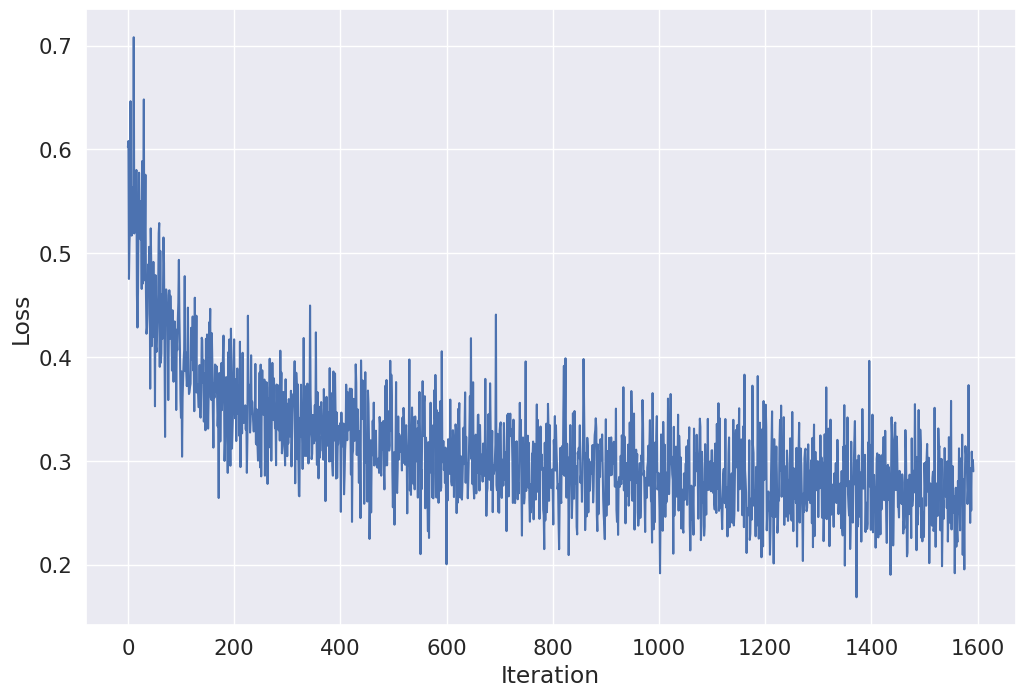

In [20]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

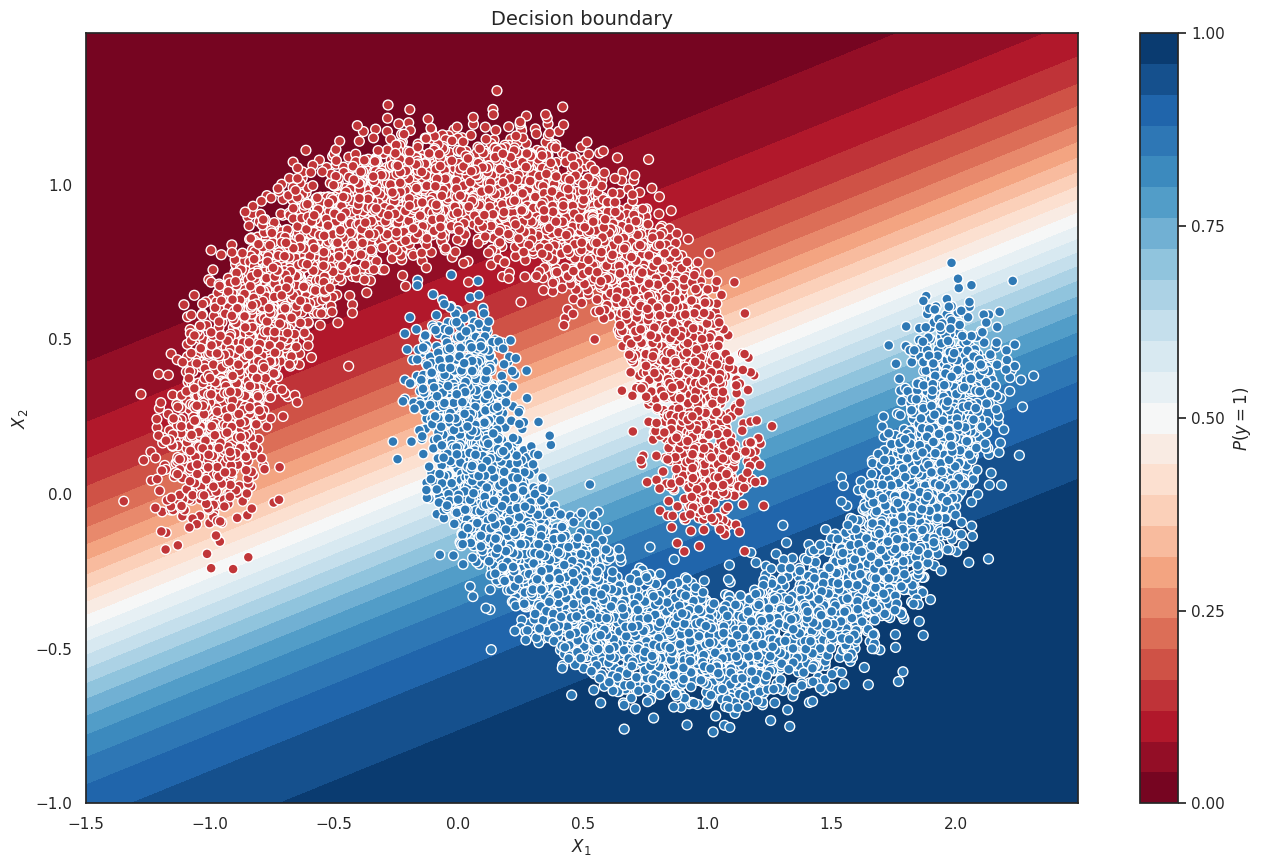

In [21]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Применим обученную модель к тестовым данным
Реализуйте функцию predict и посчитайте accuracy на test. Функция должна возвращать предсказание наиболее вероятного класса для каждого объекта из валидационой выборки:

In [29]:
@torch.no_grad()
def predict(dataloader, model):
    predictions = []

    for x_batch, _ in dataloader:
        logits = model(x_batch)
        probs = torch.sigmoid(logits)
        preds_in_batch = (probs > 0.5).int()
        predictions.append(preds_in_batch.cpu())

    return torch.cat(predictions).numpy()

Сравните предсказания наиболее вероятного класса, полученные с помощью функции predict(), с фактическими классами в валидационной выборке и рассчитайте accuracy:

In [32]:
from sklearn.metrics import accuracy_score
# YOUR CODE. Compute total accuracy
predicts = predict(val_dataloader, linear_regression)
#predicts
accuracy_score(y_val_t, predicts)

0.8852

**Вопрос 3**

Какое `accuracy` получается после обучения? (ваш ответ может варьироваться в зависимости от запуска)

**Ответ:** 0.8852

# Часть 2. Датасет MNIST

## Часть 2.1. Подготовка данных
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

### Задание. Загрузчики данных

In [33]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset_MNIST = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset_MNIST  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader_MNIST = DataLoader(train_dataset_MNIST, batch_size=128, shuffle=True)
valid_dataloader_MNIST =  DataLoader(val_dataset_MNIST, batch_size=128, shuffle=False)

# Далее будем использовать словарь из загрузчиков
loaders_MNIST = {"train": train_dataloader_MNIST, "valid": valid_dataloader_MNIST}

100%|██████████| 9.91M/9.91M [00:00<00:00, 148MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 38.8MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 115MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.82MB/s]


## Часть 2.2. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

### Задание. Модель простой полносвязной нейронной сети

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.


In [34]:
activation = nn.ELU()

model = nn.Sequential(
    nn.Flatten(),

    nn.Linear(28 * 28, 128),
    activation,

    nn.Linear(128, 128),
    activation,

    nn.Linear(128, 10)
)

Задайте лосс для обучения (кросс-энтропия).

Вспомним, что такое кросс-энтропийная функция потерь:

$$
L = -\frac{1}{N} \sum_{n=1}^{N} \sum_{i=1}^{C} y_{ni} \log(\hat{y}_{ni})
$$

где:
- $N$ — количество объектов в выборке,
- $C$ — количество классов,
- $y_{ni}$ — истинная метка (one-hot представление),
- $\hat{y}_{ni}$ — предсказанная вероятность модели для класса $i$ на примере $n$.

***Пример расчета***

Рассмотрим пример расчета кросс-энтропийной функции потерь для задачи многоклассовой классификации с 10 классами. Предположим, что у нас есть один объект, истинный класс которого известен, а модель выдала свои предсказания в виде вероятностей для каждого класса.

Пусть объект является цифрой 2. Тогда:
     $$
     y = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
     $$

Пусть модель выдала следующие вероятности для 10 классов:  
     $$
     \hat{y} = [0.1, 0.05, 0.6, 0.15, 0.05, 0.02, 0.01, 0.01, 0.01, 0.0]
     $$

$$
L = -\sum_{i=1}^{C} y_i \log(\hat{y}_i)
$$



Только один элемент $y_i$ равен 1, остальные равны 0. Поэтому:

$
L = -\sum_{i=1}^{C} y_i \log(\hat{y}_i) = - y_2 \cdot log(\hat{y}_2) = - 1 \cdot log(0.6) \approx 0.51
$

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [36]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Задание. Функции для обучения и валидации модели

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    model.train()  # <------------------ переводим модель в режим train
    for x_batch, y_batch in train_dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <--------- обнуляем градиенты модели
        outp = model(x_batch)   # <------------- получаем "логиты" из модели
        loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
        loss.backward()  # <--------------- считаем градиенты
        optimizer.step()  # <-------------- делаем шаг градиентного спуска
        count_metrics(outp, y_batch)  # <-------- считаем метрики на train датасете
     
     model.eval()  # <------------------ переводим модель в режим eval
     for x_batch, y_batch in val_dataloader:   #<--------- реализуем режим test/eval
         with torch.no_grad():  # <--------- НЕ считаем градиенты
            outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch) # <-------- считаем метрики на test датасете
        
        
```

Как и ранее обучение модели и проверку на валидационной выборке реализуем через функции. Создадим три функции:
1. для обучения модели на всей обучающей выборке (по всем батчам) на одной эпохе
2. для валидации модели на всей валидационной выборке (по всем батчам) на одной эпохе
3. для запуска функций 1. и 2. циклически по количеству эпох обучения модели

In [37]:
def fit_one_epoch(model, train_dataloader, optimizer, loss_func):
  '''
  args:
    model - модель для обучения
    train_dataloader - loader с выборкой для обучения модели
    optimizer - оптимизатор, взятый из модуля `torch.optim`
    loss_func - функция потерь, взятая из модуля `torch.nn`

  функция возвращает метрику accuracy по эпохе на данных из train_dataloader
  '''

  epoch_correct_predictions = 0.0
  epoch_all_predictions = 0.0
  # YOUR CODE. переводим модель в режим train
  model.train()

  for X_batch, y_batch in tqdm(train_dataloader):
    # Далее далее по коду идут стандартные операции цикла обучения:
    # YOUR CODE. обнуляем градиенты модели
    optimizer.zero_grad()
    outp = model(X_batch)
    loss = loss_func(outp, y_batch)

    loss.backward() # YOUR CODE. считаем градиенты
    optimizer.step() # YOUR CODE. делаем шаг градиентного спуска

    # Рассчитаем accuracy. Для этого определим количество верных предсказаний
    # и общее количество предсказаний в каждом батче, а затем накопительным итогом посчитаем
    #  количество верных предсказаний и общее количество предсказаний в рамках эпохи
    preds = outp.argmax(-1)
    batch_correct_predictions = (preds == y_batch).sum().item() # YOUR CODE GOES HERE
    batch_all_predictions = len(preds)

    epoch_correct_predictions += batch_correct_predictions # YOUR CODE GOES HERE
    epoch_all_predictions += batch_all_predictions

  epoch_accuracy = epoch_correct_predictions/epoch_all_predictions
  return epoch_accuracy

In [38]:
# проверим работу функции
fit_one_epoch(model = model, train_dataloader = train_dataloader_MNIST, optimizer = optimizer, loss_func = criterion)

  0%|          | 0/469 [00:00<?, ?it/s]

0.88925

In [41]:
def eval_one_epoch(model, val_dataloader):
  '''
  args:
    model - модель для обучения
    val_dataloader - loader с валидационной/тестовой выборкой
  '''

  epoch_correct_predictions = 0.0
  epoch_all_predictions = 0.0
  model.eval()
  with torch.no_grad():
    for X_batch, y_batch in tqdm(val_dataloader):
      # Далее далее по коду идут стандартные операции цикла валидации:
      # YOUR CODE. Не забываем отключить расчет градиентов
      outp = model(X_batch) # YOUR CODE. Получаем "логиты" из модели
      preds = outp.argmax(-1) # YOUR CODE. Определяем нииболее вероятный класс для каждого объекта в батче

      # Рассчитаем accuracy
      batch_correct_predictions = (preds == y_batch).sum().item() # YOUR CODE GOES HERE
      batch_all_predictions = len(preds) # YOUR CODE GOES HERE

      epoch_correct_predictions += batch_correct_predictions # YOUR CODE GOES HERE
      epoch_all_predictions += batch_all_predictions # YOUR CODE GOES HERE

    epoch_accuracy = epoch_correct_predictions / epoch_all_predictions # YOUR CODE GOES HERE
  return epoch_accuracy

In [42]:
# проверим работу функции
eval_one_epoch(model = model, val_dataloader = valid_dataloader_MNIST)

  0%|          | 0/79 [00:00<?, ?it/s]

0.9383

Ниже представлена функция, с помощью которой мы будем обучать модели. Эта функция вызывает fit_one_epoch() с числом раз, равным количеству эпох. Каждую эпоху также вызывается функция eval_one_epoch() для расчета accuracy на валидационной выборке.

Функция возвращает словарь с accuracy на обучающей и валидационной выборках на каждой эпохе.       

In [45]:
def train_func(model, num_epochs, dataloaders, optimizer, loss_func):
    '''
    args:
      model - модель для обучения
      num_epochs - количество эпох
      dataloaders - словарь loader'ов с обучающей и валидационной выборками
      optimizer - оптимизатор, взятый из модуля `torch.optim`
      loss_func - функция потерь, взятая из модуля `torch.nn`

    функция возвращает accuracy на обучающей и валидационной выборках на каждой эпохе
    '''

    accuracy = {"train": [], "valid": []}
    for epoch in range(num_epochs):
        print(f"\nEpoch: {epoch+1}")

        accuracy_train_one_epoch = fit_one_epoch(model=model, train_dataloader=dataloaders['train'], optimizer=optimizer, loss_func=loss_func)
        print(f"Accuracy_train: {accuracy_train_one_epoch}\n")  # УБРАТЬ .item()

        accuracy_test_one_epoch = eval_one_epoch(model=model, val_dataloader=dataloaders['valid'])
        print(f"Accuracy_test: {accuracy_test_one_epoch}\n")  # УБРАТЬ .item()

        accuracy['train'].append(accuracy_train_one_epoch)
        accuracy['valid'].append(accuracy_test_one_epoch)

    return accuracy

In [46]:
# Заново инициируем модель (для этого запустите код с инициацией в начале части 2.2. задания) и запустим обучение на 10 эпохах
optimizer = torch.optim.Adam(model.parameters())
max_epochs = 10
accuracy = train_func(model = model, num_epochs = max_epochs, dataloaders = loaders_MNIST, optimizer = optimizer, loss_func = criterion)


Epoch: 1


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.9633666666666667



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.964


Epoch: 2


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.9718666666666667



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.9695


Epoch: 3


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.9757166666666667



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.9623


Epoch: 4


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.97975



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.9744


Epoch: 5


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.9826833333333334



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.9748


Epoch: 6


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.9845833333333334



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.976


Epoch: 7


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.9863



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.977


Epoch: 8


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.988



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.978


Epoch: 9


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.9886666666666667



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.9777


Epoch: 10


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.9899



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.9793



### Функции активации

Функции активации добавляют ***нелинейность в модель***, что позволяет сети решать сложные задачи, такие как классификация и регрессия. Без функций активации нейронная сеть была бы линейной моделью, так как ***композиция линейных преобразований*** это ***линейное преобразование***.

**ReLU (Rectified Linear Unit)**
   - Формула: $ f(x) = \max(0, x) $
   - Диапазон значений: $ [0, \infty) $

**Leaky ReLU**
   - Формула: $ f(x) = \max(\alpha x, x) $, где $ \alpha $ — маленькое положительное число (обычно $ \alpha = 0.01 $).
   - Диапазон значений: $ (-\infty, \infty) $

**Exponential Linear Unit (ELU)**
   - Формула:
   $f(x) = $
     \begin{cases}
     x & \text{если } x > 0 \\
     \alpha (e^x - 1) & \text{если } x \leq 0
     \end{cases}
   - Диапазон значений:  $ (-\alpha, \infty) $

**Tanh (Гиперболический тангенс)**

  - Формула: $f(x) = \tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$
  - Диапазон значений: $(-1, 1)$

**Линейная функция активации**
   - Формула: $ f(x) = x $
   - Диапазон значений: $ (-\infty, \infty) $

   Обратите внимание, что данная функция активации **не добавляет** нелинейности.

#### Задание на дополнительный балл (3 балла)


Давайте попробуем закодировать наши функции активаций, а также потренируемся считать их градиенты.

Напишите классы для каждой из функций активации, а также для градиентов:

1. Leaky ReLU (1.5 балл: 0.5 forward pass, 1 -- backward (grad))

2. Tanh (1.5 балл: 0.5 forward pass, 1 -- backward (grad))

Для того, чтобы было понятнее, что нужно сделать -- приведём пример

In [47]:
class ReLU(nn.Module):
  def __init__(self, ):
    super().__init__()


  def forward(self, x):
    return torch.maximum(torch.zeros_like(x), x)

  def backward(self, x):
    grads = torch.zeros_like(x)
    grads[x > 0] = 1
    return grads


In [48]:
# test forward pass

torch_relu = nn.ReLU()
your_relu = ReLU()

x = torch.linspace(-3, 3, 100, requires_grad=True)


x_relu_custom = your_relu(x)
x_relu_torch = torch_relu(x)

assert torch.allclose(x_relu_custom, x_relu_torch)

In [49]:
grad_relu_custom = your_relu.backward(x)

x_relu_torch.sum().backward()
grad_relu_torch = x.grad.clone()
x.grad.zero_()

assert torch.allclose(grad_relu_custom, grad_relu_torch)

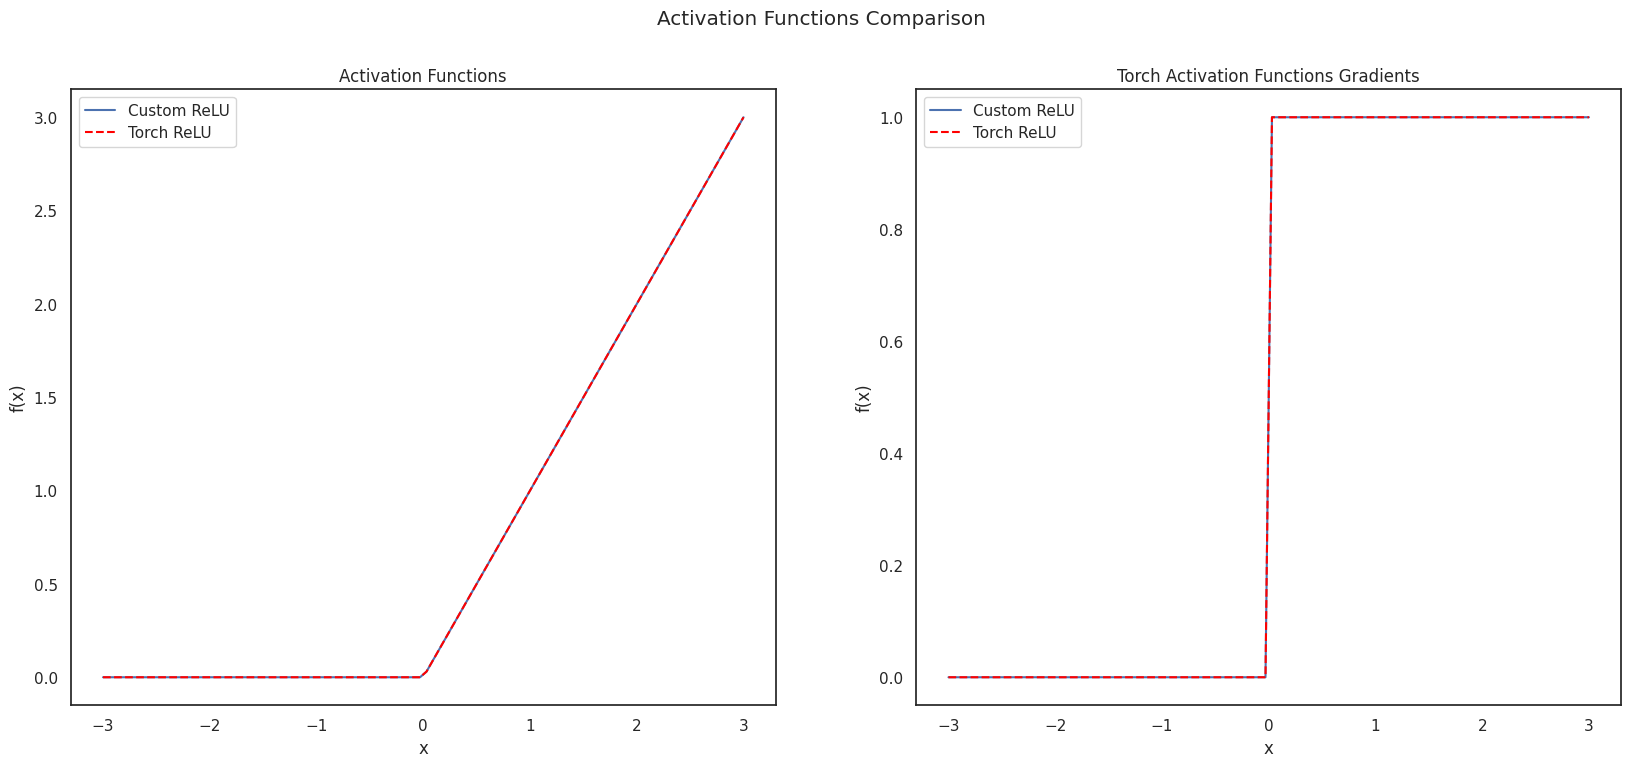

In [50]:
# Plot custom and torch functions
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle("Activation Functions Comparison")

# Plot Custom Functions
axes[0].set_title("Activation Functions")
axes[0].plot(x.detach().numpy(), x_relu_custom.detach().numpy(), label="Custom ReLU")
axes[0].plot(x.detach().numpy(), x_relu_torch.detach().numpy(), color='red', label="Torch ReLU", linestyle='--')
axes[0].legend()
axes[0].set_xlabel("x")
axes[0].set_ylabel("f(x)")

# Plot Torch Functions
axes[1].set_title("Torch Activation Functions Gradients")
axes[1].plot(x.detach().numpy(), grad_relu_custom.detach().numpy(), label="Custom ReLU")
axes[1].plot(x.detach().numpy(), grad_relu_torch.detach().numpy(), color='red', label="Torch ReLU", linestyle='--')
axes[1].legend()
axes[1].set_xlabel("x")
axes[1].set_ylabel("f(x)")

plt.show()

Теперь самостоятельно реализуйте две другие функции активаций.

In [51]:
class LeakyReLU(nn.Module):
  def __init__(self, alpha):
    super().__init__()
    self.alpha = alpha


  def forward(self, x):
    return torch.where(x > 0, x, self.alpha * x)

  def backward(self, x):
    return torch.where(x > 0, 1.0, self.alpha)

class Tanh(nn.Module):
  def __init__(self, ):
    super().__init__()


  def forward(self, x):
    return torch.tanh(x)

  def backward(self, x):
    return 1 - (torch.tanh(x)) ** 2

In [59]:
# lets test your functions with torch functions

torch_leaky_relu = nn.LeakyReLU(negative_slope=0.01)
torch_tanh = nn.Tanh()


your_leaky_relu = LeakyReLU(0.01)
your_tanh = Tanh()


In [60]:
# Test forward pass
x_leaky_custom = your_leaky_relu(x)
x_leaky_torch = torch_leaky_relu(x)

assert torch.allclose(x_leaky_custom, x_leaky_torch)

x_tanh_custom = your_tanh(x)
x_tanh_torch = torch_tanh(x)

assert torch.allclose(x_tanh_custom, x_tanh_torch)

In [61]:
grad_leaky_custom = your_leaky_relu.backward(x)


x.grad.zero_()
x_leaky_torch.sum().backward()
grad_leaky_torch = x.grad.clone()

assert torch.allclose(grad_leaky_custom, grad_leaky_torch)

grad_tanh_custom = your_tanh.backward(x)

x.grad.zero_()
x_tanh_torch.sum().backward()
grad_tanh_torch = x.grad.clone()


assert torch.allclose(grad_tanh_custom, grad_tanh_torch)


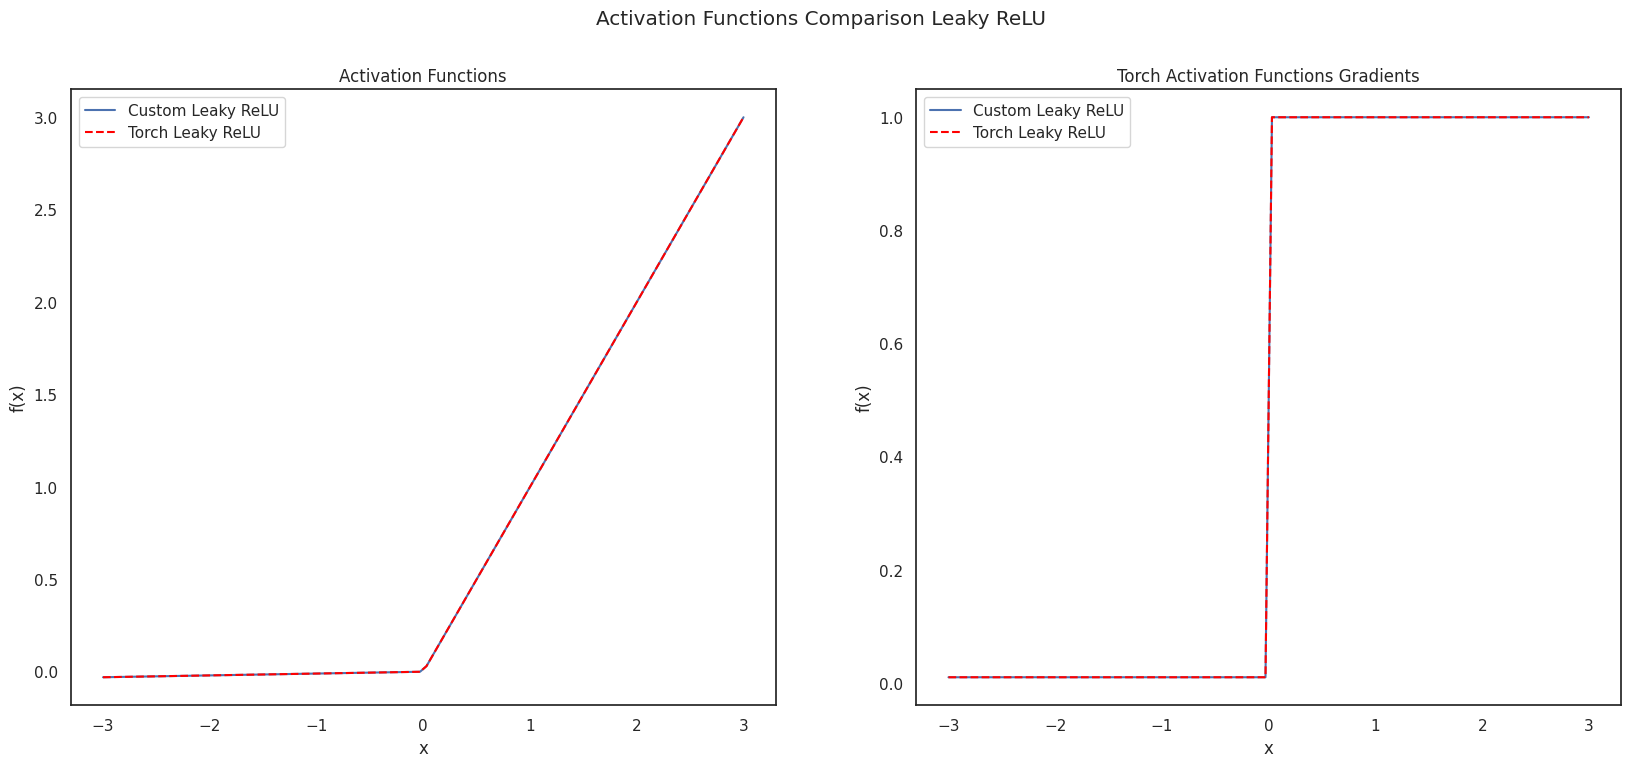

In [63]:
# Plot custom and torch functions
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle("Activation Functions Comparison Leaky ReLU")

# Plot Custom Functions
axes[0].set_title("Activation Functions")
axes[0].plot(x.detach().numpy(), x_leaky_custom.detach().numpy(), label="Custom Leaky ReLU")
axes[0].plot(x.detach().numpy(), x_leaky_torch.detach().numpy(), color='red', label="Torch Leaky ReLU", linestyle='--')
axes[0].legend()
axes[0].set_xlabel("x")
axes[0].set_ylabel("f(x)")

# Plot Torch Functions
axes[1].set_title("Torch Activation Functions Gradients")
axes[1].plot(x.detach().numpy(), grad_leaky_custom.detach().numpy(), label="Custom Leaky ReLU")
axes[1].plot(x.detach().numpy(), grad_leaky_torch.detach().numpy(), color='red', label="Torch Leaky ReLU", linestyle='--')
axes[1].legend()
axes[1].set_xlabel("x")
axes[1].set_ylabel("f(x)")

plt.show()

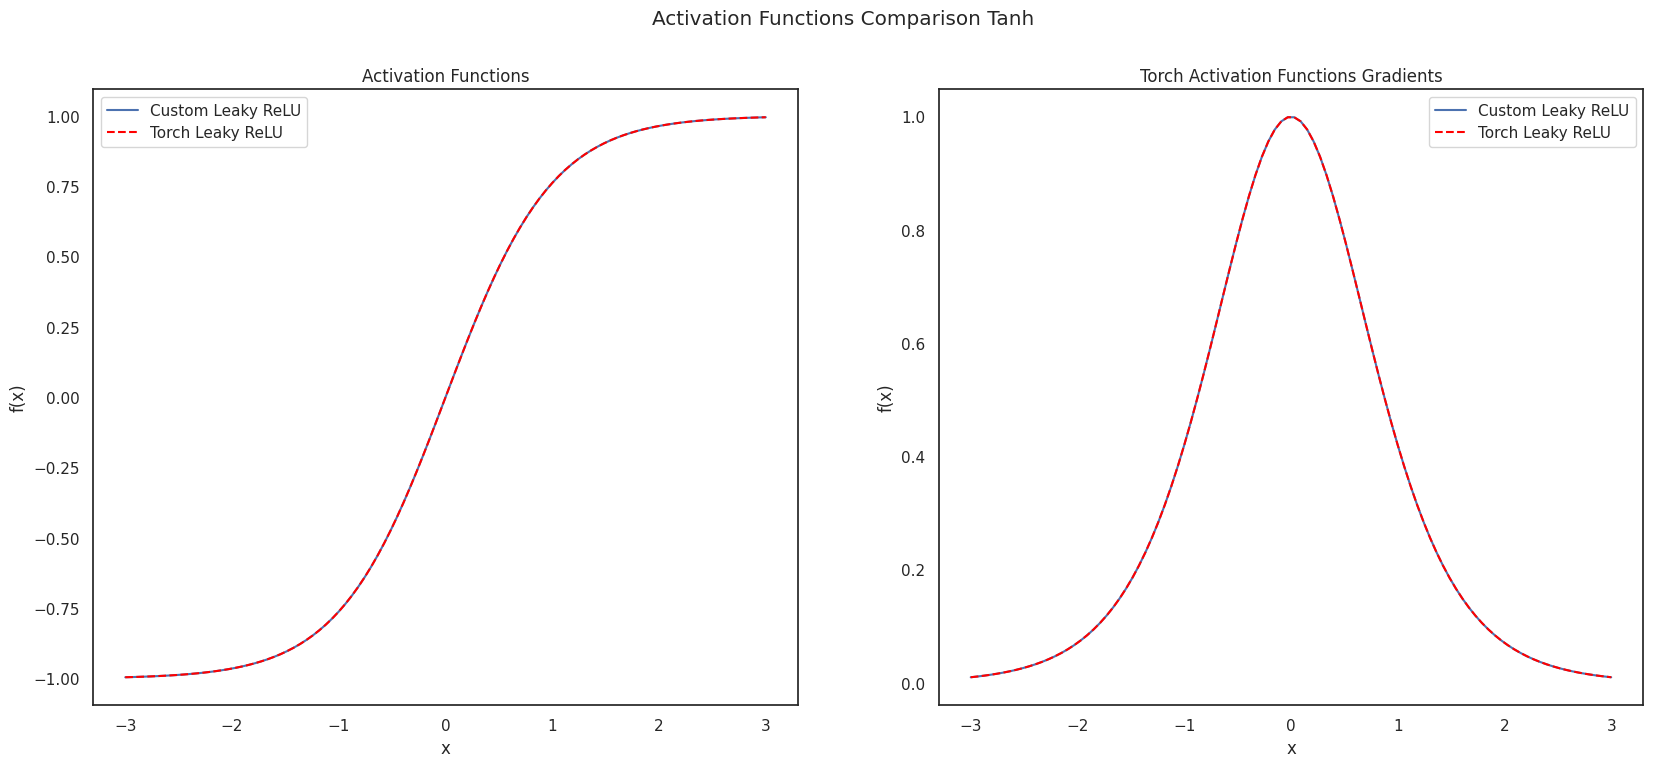

In [64]:
# Plot custom and torch functions
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle("Activation Functions Comparison Tanh")

# Plot Custom Functions
axes[0].set_title("Activation Functions")
axes[0].plot(x.detach().numpy(), x_tanh_custom.detach().numpy(), label="Custom Leaky ReLU")
axes[0].plot(x.detach().numpy(), x_tanh_torch.detach().numpy(), color='red', label="Torch Leaky ReLU", linestyle='--')
axes[0].legend()
axes[0].set_xlabel("x")
axes[0].set_ylabel("f(x)")

# Plot Torch Functions
axes[1].set_title("Torch Activation Functions Gradients")
axes[1].plot(x.detach().numpy(), grad_tanh_custom.detach().numpy(), label="Custom Leaky ReLU")
axes[1].plot(x.detach().numpy(), grad_tanh_torch.detach().numpy(), color='red', label="Torch Leaky ReLU", linestyle='--')
axes[1].legend()
axes[1].set_xlabel("x")
axes[1].set_ylabel("f(x)")

plt.show()

**Вопрос на подумать:**

Какие недостатки есть у активаций `ReLU` и как эту проблему решает `Leaky ReLU`?
* нейроны с отрицательными входами не учавствуют в работе сети
* При отрицательном входе релу на выходе имеем всегда 0, -> градиент тоже всегда 0
* Leaky ReLU решает это, позволяя нейронам с отрицательным входом обучаться и учавствовать в работе сети, не зануляя их а домножая на alpha

Что происходит с градиентами у активации `Tanh` и как это может помешать обучению?
* при больших х производная зануляется -> градиенты "исчезают" и модель медленнее обучается

#### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [65]:
# для функции активации ELU() воспользуемся полученной ранее оценкой accuracy
elu_accuracy = accuracy["valid"]

Оценку для остальных функций активации реализуем при помощи функции, которая будет инициировать и обучать модель с необходимой функцией активации:

In [66]:
def test_activation_function(activation):
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 128),
        activation,
        nn.Linear(128, 128),
        activation,
        nn.Linear(128, 10)
    )
    optimizer =  torch.optim.Adam(model.parameters())
    accuracy = train_func(model=model, num_epochs = max_epochs, dataloaders=loaders_MNIST, optimizer = optimizer, loss_func = criterion)

    return accuracy

In [67]:
plain_accuracy = test_activation_function(activation=nn.Identity())['valid']
relu_accuracy = test_activation_function(activation=nn.ReLU())['valid']
leaky_relu_accuracy = test_activation_function(activation=nn.LeakyReLU(0.01))['valid']
tanh_accuracy = test_activation_function(activation=nn.Tanh())['valid']


Epoch: 1


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.8720333333333333



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.898


Epoch: 2


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.9027333333333334



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.9077


Epoch: 3


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.9075166666666666



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.9136


Epoch: 4


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.91065



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.9132


Epoch: 5


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.9117



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.916


Epoch: 6


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.9114833333333333



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.9172


Epoch: 7


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.9145333333333333



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.9163


Epoch: 8


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.9139166666666667



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.9165


Epoch: 9


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.9158333333333334



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.9172


Epoch: 10


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.9151666666666667



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.9147


Epoch: 1


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.8727



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.9355


Epoch: 2


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.9397166666666666



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.9513


Epoch: 3


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.9571



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.9605


Epoch: 4


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.9657833333333333



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.9684


Epoch: 5


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.9699833333333333



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.9676


Epoch: 6


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.9754333333333334



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.9647


Epoch: 7


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.9777333333333333



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.9683


Epoch: 8


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.9799333333333333



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.9733


Epoch: 9


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.9829666666666667



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.9678


Epoch: 10


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.98375



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.9749


Epoch: 1


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.8756833333333334



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.9281


Epoch: 2


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.9404833333333333



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.9449


Epoch: 3


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.9565333333333333



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.9607


Epoch: 4


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.9652166666666666



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.9574


Epoch: 5


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.9702666666666667



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.9638


Epoch: 6


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.9734666666666667



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.9702


Epoch: 7


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.9785166666666667



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.9719


Epoch: 8


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.97945



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.9715


Epoch: 9


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.9816333333333334



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.9761


Epoch: 10


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.9834666666666667



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.9744


Epoch: 1


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.8976333333333333



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.9476


Epoch: 2


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.9521333333333334



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.9531


Epoch: 3


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.9642333333333334



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.9638


Epoch: 4


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.97095



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.9591


Epoch: 5


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.9738833333333333



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.9682


Epoch: 6


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.9774166666666667



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.9721


Epoch: 7


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.9801833333333333



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.9736


Epoch: 8


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.9816833333333334



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.9748


Epoch: 9


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.9827833333333333



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.9676


Epoch: 10


  0%|          | 0/469 [00:00<?, ?it/s]

Accuracy_train: 0.9830333333333333



  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy_test: 0.9744



### Визуализируем accuracy
Построим график accuracy/epoch для каждой функции активации.

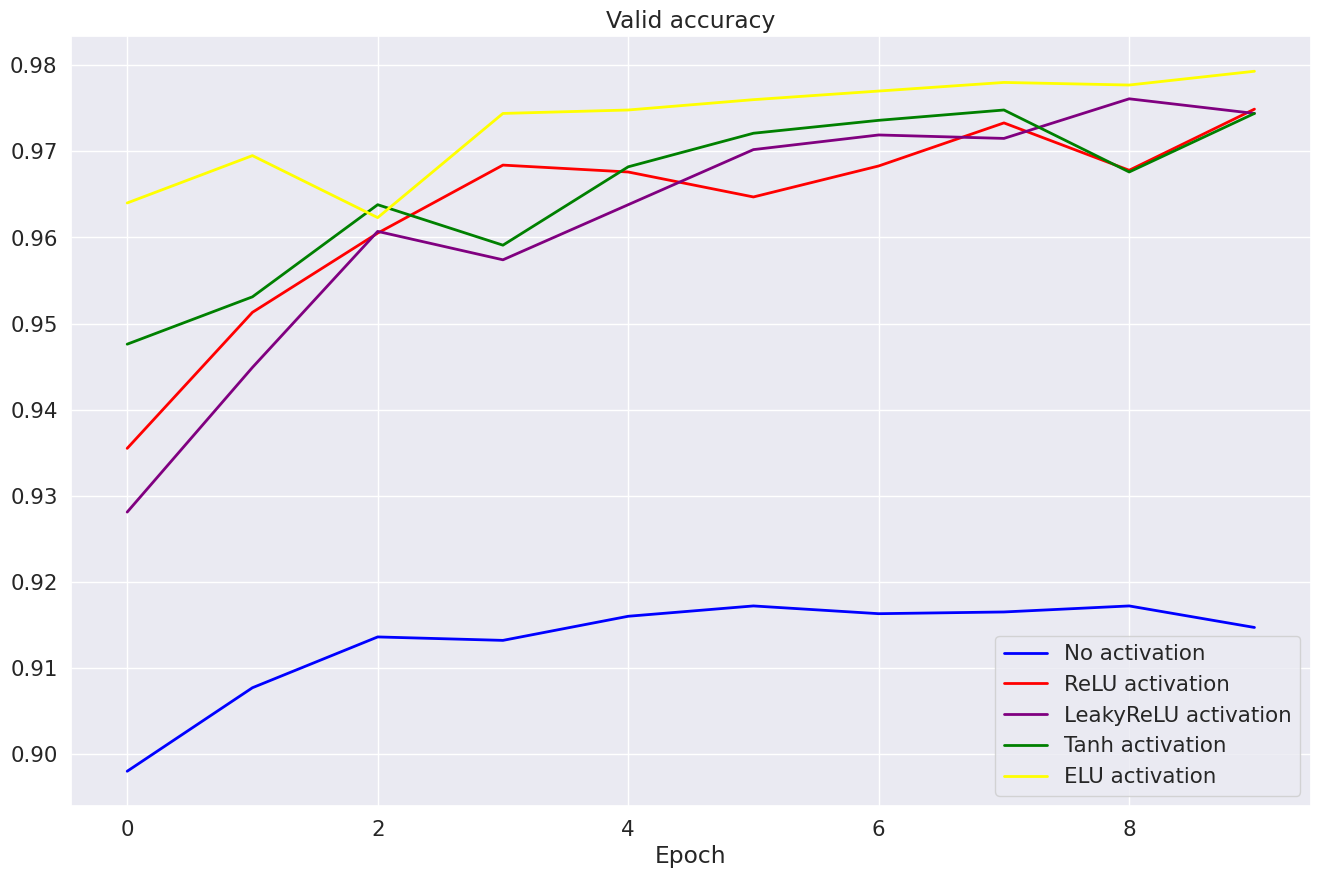

In [68]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2, color = 'blue')
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2, color = 'red')
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2, color = 'purple')
plt.plot(range(max_epochs), tanh_accuracy, label="Tanh activation", linewidth=2, color = 'green')
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2, color = 'yellow')
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ELU activation

## Часть 2.3. Сверточные нейронные сети

### Задание. Ядра свёртки
Сначала немного поработам с самим понятием ядра свёртки.

In [69]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F

In [70]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2025-11-09 00:49:33--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 5.9.226.237
Connecting to img.the-village.kz (img.the-village.kz)|5.9.226.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   259KB/s    in 0.2s    

2025-11-09 00:49:33 (259 KB/s) - ‘sample_photo.jpg’ saved [49337/49337]



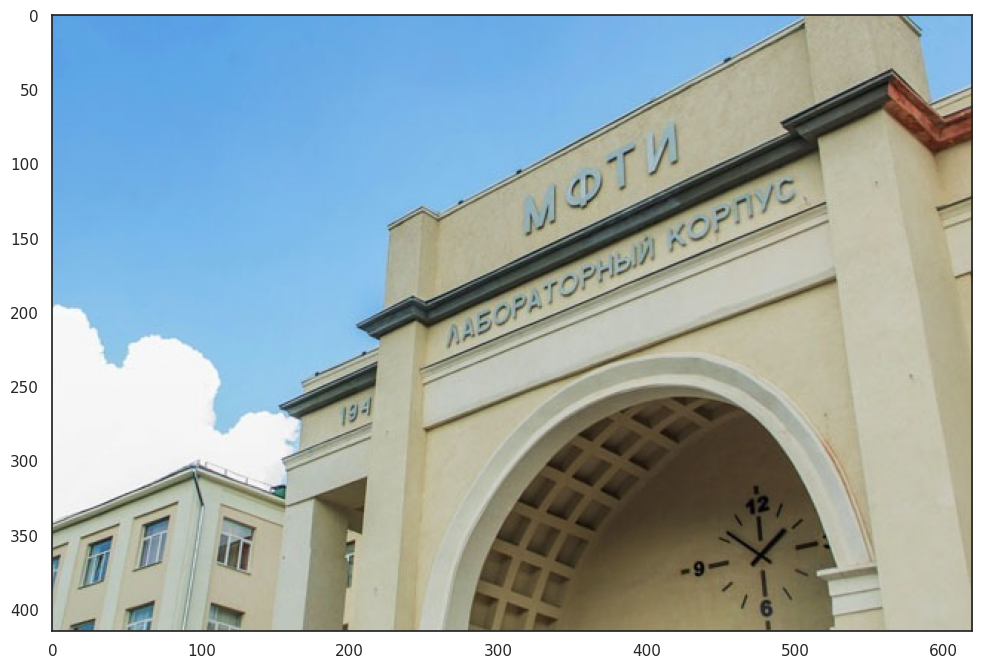

In [71]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [ ]:
conv_1 = np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]]) # A
conv_2 = np.array([[0, 1, 0], [0, -2, 0], [0, 1, 0]]) # Б
conv_3 = np.array([[0, 0, 0], [1, -2, 1], [0, 0, 0]]) # В
conv_4 = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]]) # Г
conv_5 = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]) # Д
conv_6 = np.array([[0.0625, 0.125, 0.0625], [0.125, 0.25, 0.125], [0.0625, 0.125, 0.0625]]) # E

In [ ]:
def show_conv_transformation(image, convolution):
  img_t = torch.from_numpy(image).type(torch.float32).unsqueeze(0)
  img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
  img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

  kernel = torch.tensor(convolution).reshape(1, 1, 3, 3).type(torch.float32)
  kernel = kernel.repeat(3, 3, 1, 1)

  result = F.conv2d(img_t, kernel)[0]
  result = torch.clip(input = result, min = 0, max = 256*3)

  plt.figure(figsize=(12, 8))
  result_np = result.permute(1, 2, 0).numpy() / 256 / 3
  plt.imshow(result_np)
  plt.show()

  return None

Посмотрите на работу разных сверток при помощи функции show_conv_transformation():

In [ ]:
show_conv_transformation(image = RGB_img, convolution = conv_1)

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**
А3, Б4, В5, Г6, Д2, Е1

### Задание. Реализуйте класс модели LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [76]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.fl = nn.Flatten()
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)

        x = torch.relu(self.conv2(x))
        x = self.pool2(x)

        x = self.fl(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [73]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [74]:
model_LeNet = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_LeNet.parameters())

loaders_MNIST = {"train": train_dataloader_MNIST, "valid": valid_dataloader_MNIST}

### Задание. Обучите CNN-модель
Используйте функцию для обучения модели из части задания про полносвязные нейронные сети.

В качестве возможных улучшений рекомендуем добавить туда:

1. Валидацию каждые `n` шаговь

2. Добавить сохранение промежуточных весов. Может так получиться, что с какого-то момента модель начинает переобучаться и использование весов с более ранних шагов даёт более качественный результат. Именно поэтому полезно сохранять веса не только после последней эпохи, но и с промежуточных этапов обучения.

In [85]:
def train_func_improved(model, num_epochs, dataloaders, optimizer, loss_func, save_path='checkpoints', val_every_n=100, save_every_n=2):
    '''
    Улучшенная функция обучения с:
    - Валидацией каждые n шагов
    - Сохранением промежуточных весов
    '''

    #  директория для сохранения весов
    os.makedirs(save_path, exist_ok=True)

    accuracy = {"train": [], "valid": []}
    best_accuracy = 0.

    global_step = 0

    for epoch in range(num_epochs):
        print(f"\Эпоха: {epoch+1}/{num_epochs}")

        # обучение
        model.train()
        epoch_correct = 0
        epoch_total = 0

        for batch_idx, (X_batch, y_batch) in enumerate(tqdm(dataloaders['train'])):
            global_step += 1

            # обучение на одном батче
            optimizer.zero_grad()
            outp = model(X_batch)
            loss = loss_func(outp, y_batch)
            loss.backward()
            optimizer.step()

            # accuracy для батча
            preds = outp.argmax(-1)
            batch_correct = (preds == y_batch).sum().item()
            batch_total = len(y_batch)
            epoch_correct += batch_correct
            epoch_total += batch_total

            # валидация каждые n шагов
            if global_step % val_every_n == 0:
                val_accuracy = eval_one_epoch(model, dataloaders['valid'])
                accuracy["valid"].append(val_accuracy)
                print(f"ШаГ {global_step}: accuracy на валидации = {val_accuracy:.4f}")

                #  лучшие веса
                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    torch.save(model.state_dict(), f'{save_path}/best_weights.pth')
                    print(f"Новая лучшая accuracy {best_accuracy:.4f}, веса сохранены!")

        # аccuracy на обучающей выборке за эпоху
        epoch_train_accuracy = epoch_correct / epoch_total
        accuracy["train"].append(epoch_train_accuracy)
        print(f"Эпоха {epoch+1}, Accuracy на трейне: {epoch_train_accuracy:.4f}")

        # сохранение весов каждые n эпох
        if (epoch + 1) % save_every_n == 0:
            torch.save(model.state_dict(), f'{save_path}/epoch_{epoch+1}_weights.pth')
            print(f"Веса для {epoch+1} эпохи сохранены")

    # сохраняем финальные веса
    torch.save(model.state_dict(), f'{save_path}/final_weights.pth')
    print(f"Обучение модели завершено")

    return accuracy

# обучение модели
model_lenet = LeNet()
optimizer_lenet = torch.optim.Adam(model_lenet.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

max_epochs = 10

accuracy = train_func_improved(
    model=model_lenet,
    num_epochs=max_epochs,
    dataloaders=loaders_MNIST,
    optimizer=optimizer_lenet,
    loss_func=criterion,
    save_path='lenet_checkpoints',
    val_every_n=50,  # Валидация каждые 50 шагов
    save_every_n=2   # Сохранение каждые 2 эпохи
)

lenet_accuracy = accuracy["valid"]

\Эпоха: 1/10


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 50: accuracy на валидации = 0.8049
Новая лучшая accuracy 0.8049, веса сохранены!


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 100: accuracy на валидации = 0.8962
Новая лучшая accuracy 0.8962, веса сохранены!


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 150: accuracy на валидации = 0.9249
Новая лучшая accuracy 0.9249, веса сохранены!


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 200: accuracy на валидации = 0.9418
Новая лучшая accuracy 0.9418, веса сохранены!


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 250: accuracy на валидации = 0.9512
Новая лучшая accuracy 0.9512, веса сохранены!


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 300: accuracy на валидации = 0.9573
Новая лучшая accuracy 0.9573, веса сохранены!


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 350: accuracy на валидации = 0.9613
Новая лучшая accuracy 0.9613, веса сохранены!


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 400: accuracy на валидации = 0.9656
Новая лучшая accuracy 0.9656, веса сохранены!


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 450: accuracy на валидации = 0.9677
Новая лучшая accuracy 0.9677, веса сохранены!
Эпоха 1, Accuracy на трейне: 0.8911
\Эпоха: 2/10


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 500: accuracy на валидации = 0.9681
Новая лучшая accuracy 0.9681, веса сохранены!


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 550: accuracy на валидации = 0.9705
Новая лучшая accuracy 0.9705, веса сохранены!


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 600: accuracy на валидации = 0.9737
Новая лучшая accuracy 0.9737, веса сохранены!


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 650: accuracy на валидации = 0.9718


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 700: accuracy на валидации = 0.9758
Новая лучшая accuracy 0.9758, веса сохранены!


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 750: accuracy на валидации = 0.9783
Новая лучшая accuracy 0.9783, веса сохранены!


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 800: accuracy на валидации = 0.9776


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 850: accuracy на валидации = 0.9740


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 900: accuracy на валидации = 0.9773
Эпоха 2, Accuracy на трейне: 0.9705
Веса для 2 эпохи сохранены
\Эпоха: 3/10


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 950: accuracy на валидации = 0.9779


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 1000: accuracy на валидации = 0.9748


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 1050: accuracy на валидации = 0.9796
Новая лучшая accuracy 0.9796, веса сохранены!


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 1100: accuracy на валидации = 0.9774


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 1150: accuracy на валидации = 0.9788


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 1200: accuracy на валидации = 0.9806
Новая лучшая accuracy 0.9806, веса сохранены!


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 1250: accuracy на валидации = 0.9790


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 1300: accuracy на валидации = 0.9819
Новая лучшая accuracy 0.9819, веса сохранены!


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 1350: accuracy на валидации = 0.9806


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 1400: accuracy на валидации = 0.9836
Новая лучшая accuracy 0.9836, веса сохранены!
Эпоха 3, Accuracy на трейне: 0.9782
\Эпоха: 4/10


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 1450: accuracy на валидации = 0.9827


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 1500: accuracy на валидации = 0.9811


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 1550: accuracy на валидации = 0.9849
Новая лучшая accuracy 0.9849, веса сохранены!


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 1600: accuracy на валидации = 0.9827


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 1650: accuracy на валидации = 0.9836


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 1700: accuracy на валидации = 0.9860
Новая лучшая accuracy 0.9860, веса сохранены!


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 1750: accuracy на валидации = 0.9821


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 1800: accuracy на валидации = 0.9819


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 1850: accuracy на валидации = 0.9864
Новая лучшая accuracy 0.9864, веса сохранены!
Эпоха 4, Accuracy на трейне: 0.9844
Веса для 4 эпохи сохранены
\Эпоха: 5/10


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 1900: accuracy на валидации = 0.9844


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 1950: accuracy на валидации = 0.9850


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 2000: accuracy на валидации = 0.9850


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 2050: accuracy на валидации = 0.9858


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 2100: accuracy на валидации = 0.9857


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 2150: accuracy на валидации = 0.9868
Новая лучшая accuracy 0.9868, веса сохранены!


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 2200: accuracy на валидации = 0.9864


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 2250: accuracy на валидации = 0.9863


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 2300: accuracy на валидации = 0.9855
Эпоха 5, Accuracy на трейне: 0.9873
\Эпоха: 6/10


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 2350: accuracy на валидации = 0.9869
Новая лучшая accuracy 0.9869, веса сохранены!


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 2400: accuracy на валидации = 0.9861


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 2450: accuracy на валидации = 0.9859


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 2500: accuracy на валидации = 0.9849


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 2550: accuracy на валидации = 0.9877
Новая лучшая accuracy 0.9877, веса сохранены!


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 2600: accuracy на валидации = 0.9864


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 2650: accuracy на валидации = 0.9858


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 2700: accuracy на валидации = 0.9872


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 2750: accuracy на валидации = 0.9870


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 2800: accuracy на валидации = 0.9866
Эпоха 6, Accuracy на трейне: 0.9885
Веса для 6 эпохи сохранены
\Эпоха: 7/10


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 2850: accuracy на валидации = 0.9882
Новая лучшая accuracy 0.9882, веса сохранены!


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 2900: accuracy на валидации = 0.9881


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 2950: accuracy на валидации = 0.9883
Новая лучшая accuracy 0.9883, веса сохранены!


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 3000: accuracy на валидации = 0.9857


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 3050: accuracy на валидации = 0.9877


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 3100: accuracy на валидации = 0.9867


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 3150: accuracy на валидации = 0.9860


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 3200: accuracy на валидации = 0.9869


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 3250: accuracy на валидации = 0.9891
Новая лучшая accuracy 0.9891, веса сохранены!
Эпоха 7, Accuracy на трейне: 0.9906
\Эпоха: 8/10


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 3300: accuracy на валидации = 0.9877


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 3350: accuracy на валидации = 0.9884


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 3400: accuracy на валидации = 0.9885


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 3450: accuracy на валидации = 0.9881


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 3500: accuracy на валидации = 0.9887


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 3550: accuracy на валидации = 0.9864


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 3600: accuracy на валидации = 0.9857


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 3650: accuracy на валидации = 0.9886


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 3700: accuracy на валидации = 0.9880


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 3750: accuracy на валидации = 0.9868
Эпоха 8, Accuracy на трейне: 0.9918
Веса для 8 эпохи сохранены
\Эпоха: 9/10


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 3800: accuracy на валидации = 0.9869


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 3850: accuracy на валидации = 0.9875


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 3900: accuracy на валидации = 0.9890


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 3950: accuracy на валидации = 0.9880


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 4000: accuracy на валидации = 0.9884


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 4050: accuracy на валидации = 0.9876


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 4100: accuracy на валидации = 0.9890


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 4150: accuracy на валидации = 0.9860


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 4200: accuracy на валидации = 0.9875
Эпоха 9, Accuracy на трейне: 0.9927
\Эпоха: 10/10


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 4250: accuracy на валидации = 0.9879


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 4300: accuracy на валидации = 0.9889


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 4350: accuracy на валидации = 0.9881


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 4400: accuracy на валидации = 0.9885


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 4450: accuracy на валидации = 0.9876


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 4500: accuracy на валидации = 0.9876


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 4550: accuracy на валидации = 0.9883


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 4600: accuracy на валидации = 0.9895
Новая лучшая accuracy 0.9895, веса сохранены!


  0%|          | 0/79 [00:00<?, ?it/s]

ШаГ 4650: accuracy на валидации = 0.9898
Новая лучшая accuracy 0.9898, веса сохранены!
Эпоха 10, Accuracy на трейне: 0.9938
Веса для 10 эпохи сохранены
Обучение модели завершено


In [78]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

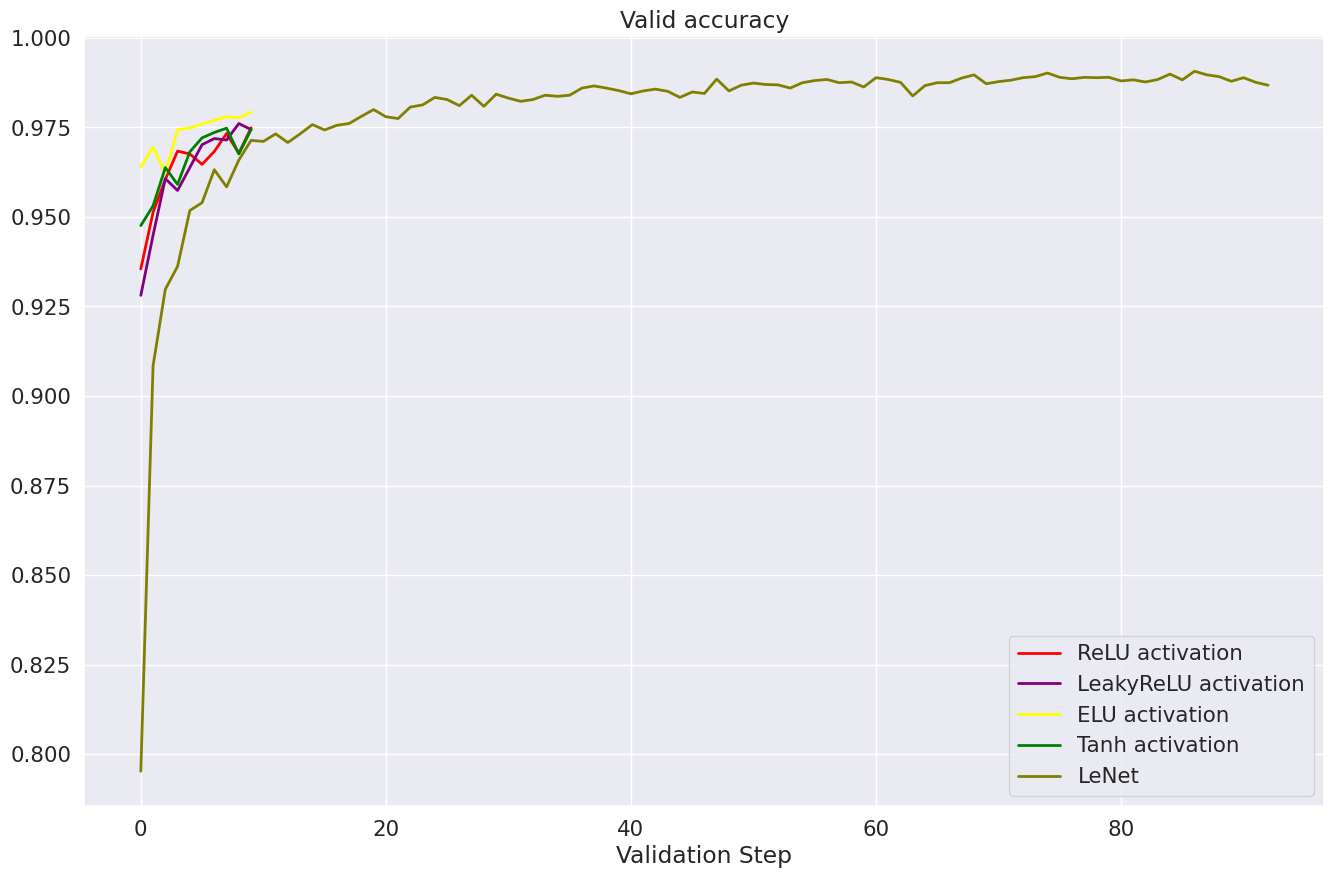

In [80]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")

# Для активационных функций (1 значение на эпоху)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2, color='red')
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2, color='purple')
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2, color='yellow')
plt.plot(range(max_epochs), tanh_accuracy, label="Tanh activation", linewidth=2, color='green')

# Для LeNet (93 значения - по шагам, а не по эпохам)
plt.plot(range(len(lenet_accuracy)), lenet_accuracy, label="LeNet", linewidth=2, color='olive')

plt.legend()
plt.xlabel("Validation Step" if len(lenet_accuracy) > max_epochs else "Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.99 [round(max(accuracy['valid']), 2) - вот так можно проверить]